#Importing modules

In [ ]:
# import modules
from IPython.display import display, clear_output
import numpy as np
import os
# import deep learning libraries
import os
import keras
import pickle
from keras import layers
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Dropout, Add, Dense, Reshape, Activation
from keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D

In [ ]:
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
from tensorflow.keras import layers
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pickle, random, sys, keras
import h5py

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow is already loaded. Please restart the runtime to change versions.
Found GPU at: /device:GPU:0


##Importing Data

In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#De-Pickling Data with encoding latin1
with open("/content/drive/MyDrive/RML2016.10a_dict.pickle.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding='latin1')

#Splitting Data for training and testing

In [ ]:
classes = ['32PSK', '16APSK', '32QAM', 'FM', 'GMSK', '32APSK', 'OQPSK', #1
 '8ASK', 'BPSK','8PSK', 'AM-SSB-SC', '4ASK', '16PSK', '64APSK', '128QAM', '128APSK','AM-DSB-SC', #2 
'AM-SSB-WC', '64QAM', 'QPSK', '256QAM','AM-DSB-WC','OOK','16QAM']

In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

In [ ]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [ ]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [ ]:
trainy = list(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_train = to_onehot(trainy)
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

#Sequential Model Keras 

In [ ]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods
# %%
dr = 0.5 
# Reshape [N,2,128] to [N,1,2,128] on input
input_x = Input(shape=(1,2,128))
input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(input_x)

layer11 = Conv2D(50, (1, 1), padding='valid', activation="relu", name="conv11", kernel_initializer='glorot_uniform',
                 data_format="channels_first")(input_x_padding)
layer11 = Dropout(dr)(layer11)

layer11 = ZeroPadding2D((0, 2), data_format="channels_first")(layer11)
layer12 = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv12", kernel_initializer='glorot_uniform',
                 data_format="channels_first")(layer11)
layer12 = Dropout(dr)(layer12)

layer21 = Conv2D(50, (1, 1), padding='valid', activation="relu", name="conv21", kernel_initializer='glorot_uniform',
                 data_format="channels_first")(input_x_padding)
layer21 = Dropout(dr)(layer21)

layer21 = ZeroPadding2D((0, 2), data_format="channels_first")(layer21)
layer22 = Conv2D(50, (1, 3), padding="valid", activation="relu", name="conv22", kernel_initializer='glorot_uniform',
                 data_format="channels_first")(layer21)
layer22 = Dropout(dr)(layer22)

layer31 = Conv2D(50, (1, 1), padding='valid', activation="relu", name="conv31", kernel_initializer='glorot_uniform',
                 data_format="channels_first")(input_x_padding)
layer31 = Dropout(dr)(layer31)

concat = keras.layers.concatenate([layer12, layer22, layer31])
layer_Flatten = Flatten()(concat)
layer_dense1 = Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1")(layer_Flatten)
layer_dropout = Dropout(dr)(layer_dense1)
layer_dense2 = Dense(len(classes), kernel_initializer='he_normal', name="dense2")(layer_dropout)
layer_softmax = Activation('softmax')(layer_dense2)
output = Reshape([len(classes)])(layer_softmax)

model = Model(inputs=input_x, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

(110000, 1, 2, 128) [1, 2, 128]
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 2, 128)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 1, 2, 132)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv11 (Conv2D)                 (None, 50, 2, 132)   100         zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv21 (Conv2D)                 (None, 50, 2, 132)   100         zero_padding2d_3[0][0]           
____________________________________________________________

#Training the model

In [ ]:
# %%
# Set up some params
epochs = 100  # number of epochs to train on
batch_size = 1024  # training batch size default1024
# %%
filepath = "convmodrecnets_%s_0.5.wts.h5" 

X_train = np.reshape(X_train, (-1,1,2,128))
X_test = np.reshape(X_test, (-1,1,2,128))

history = model.fit(X_train,
                    Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks=[
                        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                                                        mode='auto'),
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto'),
                        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto',
                                                          epsilon=0.0001, cooldown=0, min_lr=0)
                    ])

Epoch 1/100
108/108 [==============================] - 12s 101ms/step - loss: 2.2811 - accuracy: 0.1502 - val_loss: 1.9682 - val_accuracy: 0.2795
Epoch 2/100
108/108 [==============================] - 11s 100ms/step - loss: 1.9580 - accuracy: 0.2729 - val_loss: 1.8624 - val_accuracy: 0.3067
Epoch 3/100
108/108 [==============================] - 11s 101ms/step - loss: 1.8670 - accuracy: 0.2961 - val_loss: 1.7534 - val_accuracy: 0.3385
Epoch 4/100
108/108 [==============================] - 11s 101ms/step - loss: 1.7976 - accuracy: 0.3179 - val_loss: 1.7137 - val_accuracy: 0.3499
Epoch 5/100
108/108 [==============================] - 11s 102ms/step - loss: 1.7659 - accuracy: 0.3253 - val_loss: 1.6821 - val_accuracy: 0.3596
Epoch 6/100
108/108 [==============================] - 11s 102ms/step - loss: 1.7300 - accuracy: 0.3402 - val_loss: 1.6477 - val_accuracy: 0.3807
Epoch 7/100
108/108 [==============================] - 11s 102ms/step - loss: 1.6875 - accuracy: 0.3567 - val_loss: 1.5996 -

#Results



> Loss And Accuracy



In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print("Validation Loss and Accuracy: ",score)

Validation Loss and Accuracy:  [1.3564045429229736, 0.4874090850353241]


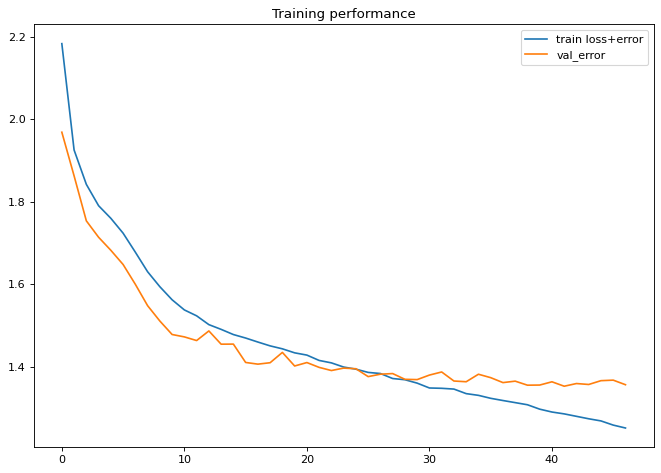

In [ ]:
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='black')
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.show()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

>Confusion Matrix

In [ ]:
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

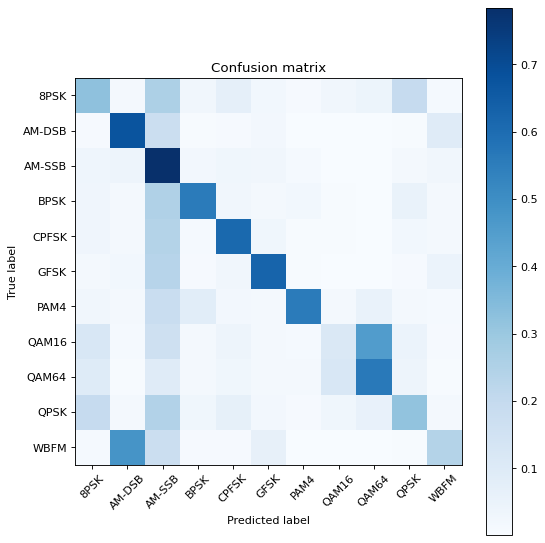

In [ ]:
figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='black')
plot_confusion_matrix(confnorm, labels=classes)

>Accuracy

In [ ]:
acc = {}
for snr in snrs:
  # extract classes @ SNR
  test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
  test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
  test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]
  # estimate classes
  test_Y_i_hat = model.predict(test_X_i)
  conf = np.zeros([len(classes),len(classes)])
  confnorm = np.zeros([len(classes),len(classes)])
  for i in range(0,test_X_i.shape[0]):
    j = list(test_Y_i[i,:]).index(1)
    k = int(np.argmax(test_Y_i_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

  #plt.figure()
  #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
  cor = np.sum(np.diag(conf))
  ncor = np.sum(conf) - cor
  print("SNR: ",snr, " Overall Accuracy: ", cor / (cor + ncor))
  acc[snr] = 1.0 * cor / (cor + ncor)

SNR:  -20  Overall Accuracy:  0.1000914913083257
SNR:  -18  Overall Accuracy:  0.09355131698455948
SNR:  -16  Overall Accuracy:  0.10003617945007236
SNR:  -14  Overall Accuracy:  0.11530133525802959
SNR:  -12  Overall Accuracy:  0.1440291704649043
SNR:  -10  Overall Accuracy:  0.21681180024880042
SNR:  -8  Overall Accuracy:  0.3077347051258497
SNR:  -6  Overall Accuracy:  0.43914956011730205
SNR:  -4  Overall Accuracy:  0.5526802218114603
SNR:  -2  Overall Accuracy:  0.6298984034833092
SNR:  0  Overall Accuracy:  0.6751824817518248
SNR:  2  Overall Accuracy:  0.6786623046165031
SNR:  4  Overall Accuracy:  0.70356093979442
SNR:  6  Overall Accuracy:  0.7102888086642599
SNR:  8  Overall Accuracy:  0.715058611361587
SNR:  10  Overall Accuracy:  0.7205828779599271
SNR:  12  Overall Accuracy:  0.7115697990222705
SNR:  14  Overall Accuracy:  0.7147075106108138
SNR:  16  Overall Accuracy:  0.7042533936651584
SNR:  18  Overall Accuracy:  0.7202520252025203


In [ ]:
SNR:  -20  Overall Accuracy:  0.1000914913083257
SNR:  -18  Overall Accuracy:  0.09355131698455948
SNR:  -16  Overall Accuracy:  0.10003617945007236
SNR:  -14  Overall Accuracy:  0.11530133525802959
SNR:  -12  Overall Accuracy:  0.1440291704649043
,  0.21681180024880042
,  0.3077347051258497
,  0.43914956011730205
,  0.5526802218114603
,  0.6298984034833092
,  0.6751824817518248
,  0.6786623046165031
,  0.70356093979442
, 0.7102888086642599
, 0.715058611361587
,  0.7205828779599271
, 0.7115697990222705
,  0.7147075106108138
,  0.7042533936651584
,  0.7202520252025203

{-20: 0.1000914913083257, -18: 0.09355131698455948, -16: 0.10003617945007236, -14: 0.11530133525802959, -12: 0.1440291704649043, -10: 0.21681180024880042, -8: 0.3077347051258497, -6: 0.43914956011730205, -4: 0.5526802218114603, -2: 0.6298984034833092, 0: 0.6751824817518248, 2: 0.6786623046165031, 4: 0.70356093979442, 6: 0.7102888086642599, 8: 0.715058611361587, 10: 0.7205828779599271, 12: 0.7115697990222705, 14: 0.7147075106108138, 16: 0.7042533936651584, 18: 0.7202520252025203}


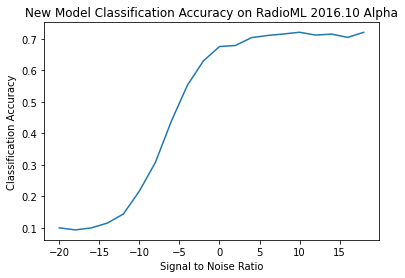

In [ ]:
print(acc)
fd = open('results_cnn_d0.5.dat','wb')
pickle.dump( ("CNN", 0.5, acc) , fd )

# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("New Model Classification Accuracy on RadioML 2016.10 Alpha")
plt.show()